In [1]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import h5py

Matplotlib created a temporary cache directory at /tmp/matplotlib-_estms7c because the default path (/home/jupyter-ikharitonov/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# cache_dir = os.path.expanduser()
# cache_subdir = "hdspikes"
# get_shd_dataset(cache_dir, cache_subdir)

train_file = h5py.File(Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_train.h5", 'r')
test_file = h5py.File(Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_test.h5", 'r')

x_train = train_file['spikes']
y_train = train_file['labels']
x_test = test_file['spikes']
y_test = test_file['labels']

In [8]:
y_train[0]

11

In [3]:
x_train['times'][0]
# x_test['times'].shape

array([0.      , 0.001833, 0.002167, ..., 0.698   , 0.6997  , 0.7007  ],
      dtype=float16)

In [42]:
y_train[-1]

1

In [74]:
speaker_digit_ids.shape

(8156,)

array([ 2, 11,  0, ...,  0,  9,  6], dtype=uint16)

In [73]:
train_file['labels']

<HDF5 dataset "labels": shape (8156,), type "<u2">

In [216]:
def get_digit_inds(speaker_id, digit):
    speaker_digit_ids = np.array(train_file['extra']['speaker'])

    inds1 = np.where(speaker_digit_ids == speaker_id)

    digit_labels = np.array(train_file['labels'])
    digit_labels[inds1]

    inds2 = np.where(digit_labels[inds1] < 10) # only english 0-9

    speaker_english_digits_ids = inds1[0][inds2]

    inds3 = np.where(train_file['labels'][speaker_english_digits_ids] == digit)
    digits_inds = speaker_english_digits_ids[inds3]

    return digits_inds

def get_digit_data(filepath, indices):
    data_file = h5py.File(filepath, 'r')
    trials_units = train_file['spikes']['units'][indices]
    trials_times = train_file['spikes']['times'][indices]
    
    return trials_units, trials_times, len(trials_units)
    
def convert_for_plotting(trial_units, trial_times):
    spike_data = []

    for unit_id in np.unique(trial_units):
        inds = np.where(trial_units == unit_id)
        spike_data.append(list(trial_times[inds]))
    return spike_data
    
get_digit_inds(0, 9).shape
units, times, trials_num = get_digit_data(Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_train.h5", get_digit_inds(0, 9))

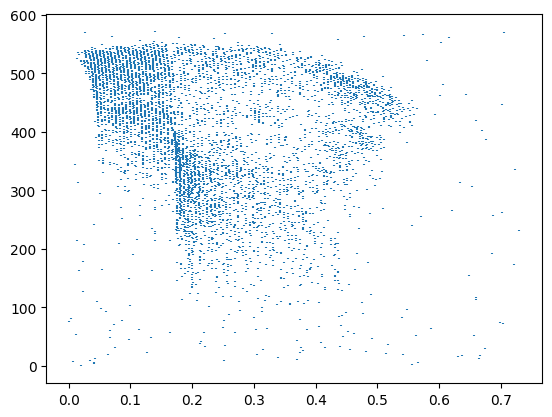

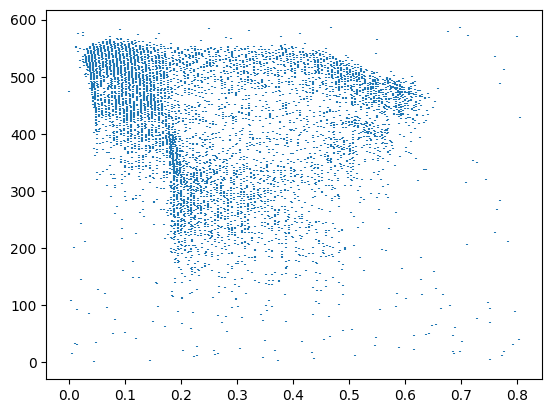

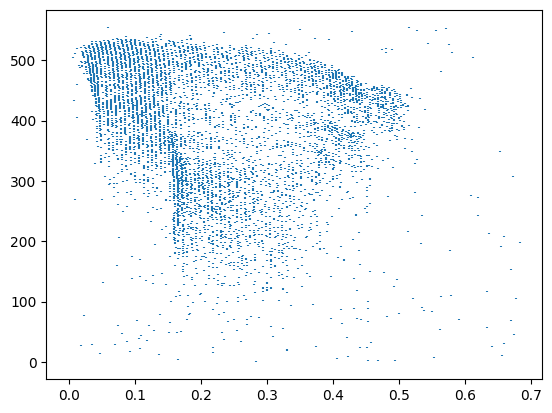

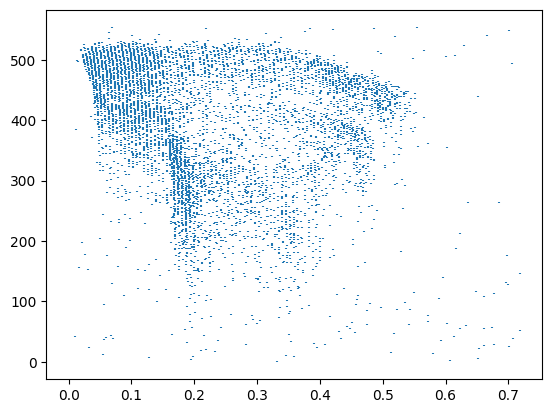

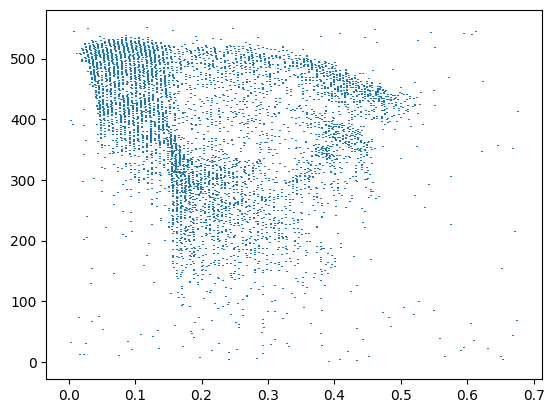

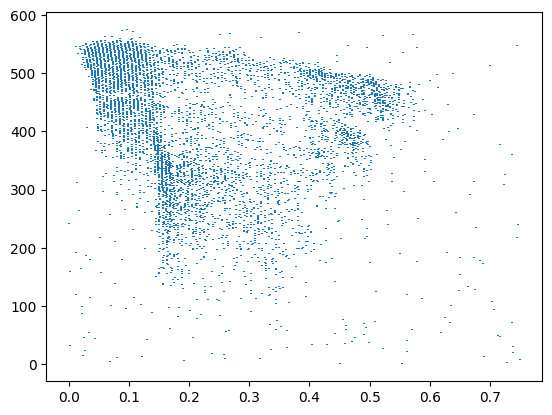

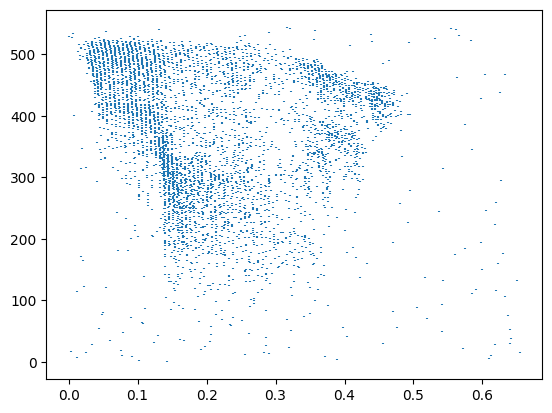

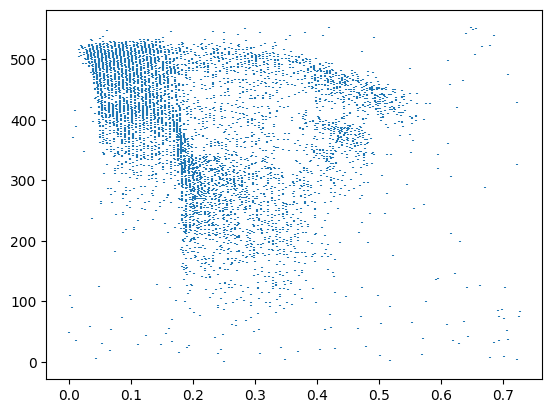

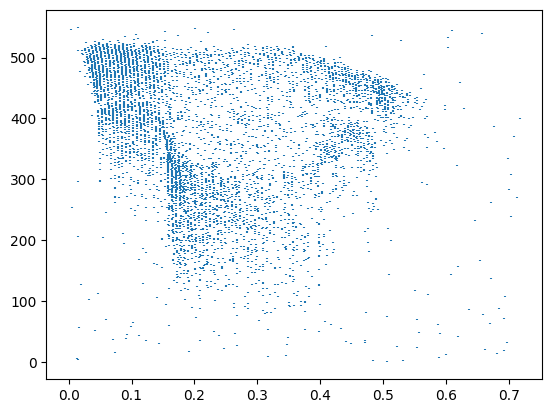

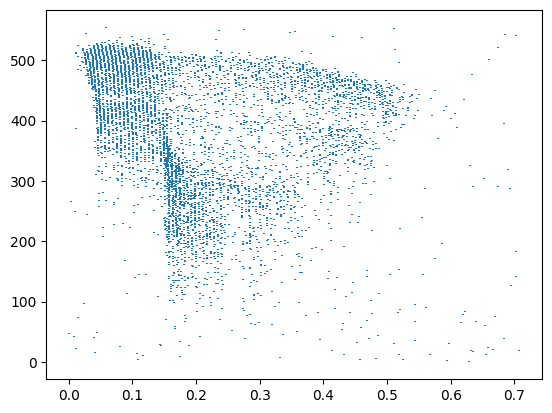

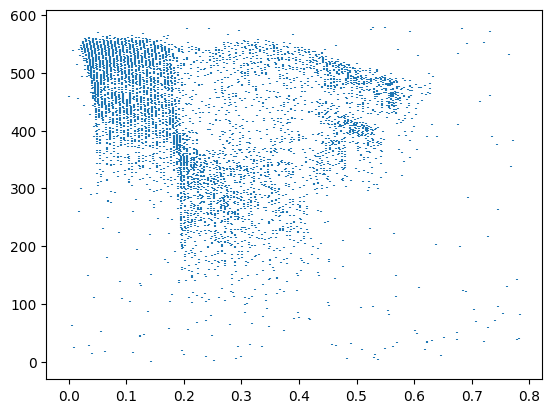

In [495]:
trials_units = train_file['spikes']['units'][digits_inds]
trials_times = train_file['spikes']['times'][digits_inds]

for i in range(len(trials_units)//4):

    spike_data = convert_for_plotting(trials_units[i], trials_times[i])

    plt.eventplot(spike_data)
    plt.show()

## pairing consecutive digits

In [157]:
units, times, trials_num = get_digit_data(Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_train.h5", get_digit_inds(0, 9))

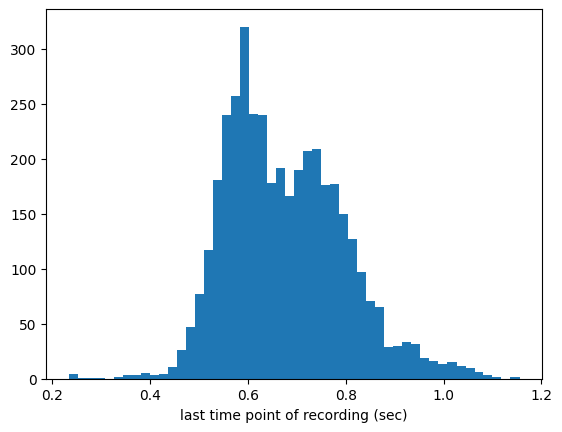

In [161]:
speakers = [0,1,2,3,6,7,8,9,10,11]
digits = [0,1,2,3,4,5,6,7,8,9]

ending_times = []

for s in speakers:
    for d in digits:
        _,times,trials_num = get_digit_data(Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_train.h5", get_digit_inds(s, d))
        for i in range(trials_num):
            # print(times[i][-1])
            ending_times.append(times[i][-1])

plt.hist(ending_times, bins=50)
plt.xlabel('last time point of recording (sec)')
plt.show()

In [202]:
units1, times1, trials_num1 = get_digit_data(Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_train.h5", get_digit_inds(0, 1))

units2, times2, trials_num2 = get_digit_data(Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_train.h5", get_digit_inds(0, 2))

units3, times3, trials_num3 = get_digit_data(Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_train.h5", get_digit_inds(0, 3))

In [203]:
print(trials_num1)
print(trials_num2)
print(trials_num3)

47
48
47


In [572]:
# find the minimum length of concatenated array and cut to it
def trim_to_length(units_arr, times_arr, max_time_cut=False):
    if max_time_cut:
        temp_units_arr, temp_times_arr = [], []
        for i in range(trials_num1):
            inds = np.where(times_arr[i] >= max_time_cut)
            if len(inds[0]) == 0:
                temp_units_arr.append(units_arr[i])
                temp_times_arr.append(times_arr[i])
            else:
                temp_units_arr.append(units_arr[i][:inds[0][0]])
                temp_times_arr.append(times_arr[i][:inds[0][0]])
        units_arr, times_arr = temp_units_arr, temp_times_arr
    else:
        min_length = units_arr[0].shape[0]
        for i in range(1,trials_num1):
            new_length = units_arr[i].shape[0]
            if new_length < min_length: min_length = new_length
        units_arr = [x[:min_length] for x in units_arr]
        times_arr = [x[:min_length] for x in times_arr]
    return units_arr, times_arr

def resample(units_arr, times_arr, duration, frequency, pad_length=None):
    
    t = np.linspace(0,duration,int(frequency*duration))
    all_units_list = np.unique(units_arr)
    spikes = np.zeros((t.shape[0], all_units_list.shape[0]))
    # units_spiked = [[] for i in range(len(spikes))] # nested list
    
    for i, spike in enumerate(times_arr):
        t_ind = np.where(t <= spike)[0][-1] # assign the spike to the closest smaller time bin
        u_ind = np.where(all_units_list==units_arr[i])
        
        spikes[t_ind, u_ind] = 1
        # units_spiked[t_ind].append(units_arr[i])
        
    if pad_length:
        if spikes.shape[1] > pad_length:
            spikes = spikes[:, :pad_length]
        elif spikes.shape[1] < pad_length:
            diff = pad_length - spikes.shape[1]
            spikes = np.concatenate((spikes, np.zeros((t.shape[0], diff))), axis=1)
    
    return t, spikes

def convert_for_plotting2(t, spikes):
    # used for resampled data format
    spike_data = [t[np.where(spikes[:, u_id]==1)] for u_id in range(spikes.shape[1])]
            
    return spike_data

In [567]:
spikes[:].shape

(1500, 650)

In [568]:
MAX_TIME = 1.5 # (seconds) - all recordings are cut at this time

In [569]:
# PAIRING DIGITS TOGETHER
units12 = []
times12 = []

for i in range(trials_num1): # combine each of 47 trials
    units12.append(np.concatenate((units1[i], units2[i])))
    times12.append(np.concatenate((times1[i], times2[i] + times1[i][-1])))

units12, times12 = trim_to_length(units12, times12, max_time_cut=MAX_TIME)



units23 = []
times23 = []

for i in range(trials_num1): # combine each of 47 trials
    units23.append(np.concatenate((units2[i], units3[i])))
    times23.append(np.concatenate((times2[i], times3[i] + times2[i][-1])))
    
units23, times23 = trim_to_length(units23, times23, max_time_cut=MAX_TIME)



units31 = []
times31 = []

for i in range(trials_num1): # combine each of 47 trials
    units31.append(np.concatenate((units3[i], units1[i])))
    times31.append(np.concatenate((times3[i], times1[i] + times3[i][-1])))

units31, times31 = trim_to_length(units31, times31, max_time_cut=MAX_TIME)

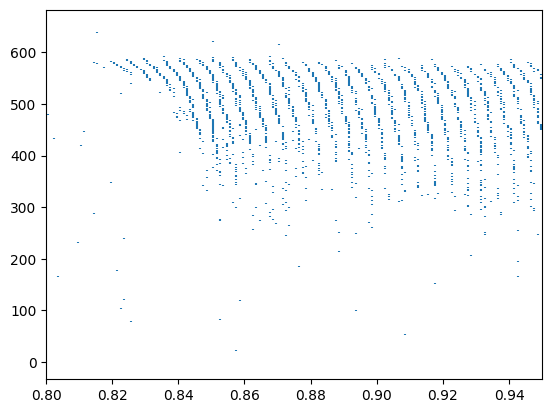

In [573]:
# RESAMPLED AT 1 kHZ

trial_id = 0

t, spikes = resample(units12[trial_id], times12[trial_id], 1.5, 1000, pad_length=650)
spike_data = convert_for_plotting2(t, spikes)

plt.eventplot(spike_data)
plt.xlim([0.8,0.95])
plt.show()

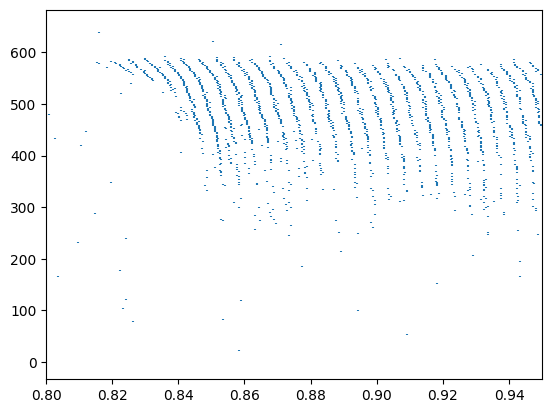

In [575]:
# RESAMPLED AT 10 kHZ

trial_id = 0

t, spikes = resample(units12[trial_id], times12[trial_id], 1.5, 10000, pad_length=650)
spike_data = convert_for_plotting2(t, spikes)

plt.eventplot(spike_data)
plt.xlim([0.8,0.95])
plt.show()

In [534]:
FREQ = 1000
PAD_LENGTH = 650

In [577]:
# RESAMPLING
spikes12, plot_spikes12 = {}, {}
spikes23, plot_spikes23 = {}, {}
spikes31, plot_spikes31 = {}, {}
# trial_unit_num12 = {}
# trial_unit_num23 = {}
# trial_unit_num31 = {}

for i in range(trials_num1):
    t, spikes12[i] = resample(units12[i], times12[i], MAX_TIME, FREQ, pad_length = PAD_LENGTH)
    plot_spikes12[i] = convert_for_plotting2(t, spikes12[i])
    # trial_unit_num12[i] = len(plot_spikes12[i]) # for keeping track of the number of units in each trial, recording
    
    t, spikes23[i] = resample(units23[i], times23[i], MAX_TIME, FREQ, pad_length = PAD_LENGTH)
    plot_spikes23[i] = convert_for_plotting2(t, spikes23[i])
    # trial_unit_num23[i] = len(plot_spikes23[i])
    
    t, spikes31[i] = resample(units31[i], times31[i], MAX_TIME, FREQ, pad_length = PAD_LENGTH)
    plot_spikes31[i] = convert_for_plotting2(t, spikes31[i])
    # trial_unit_num31[i] = len(plot_spikes31[i])

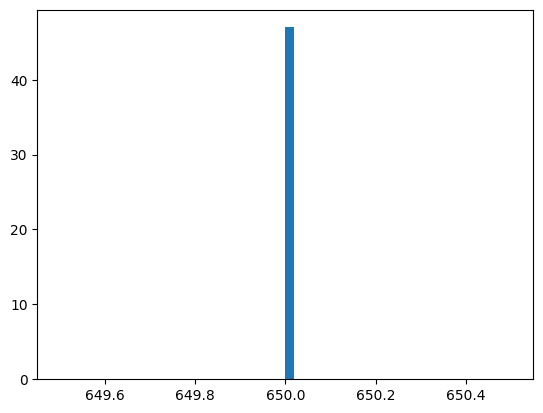

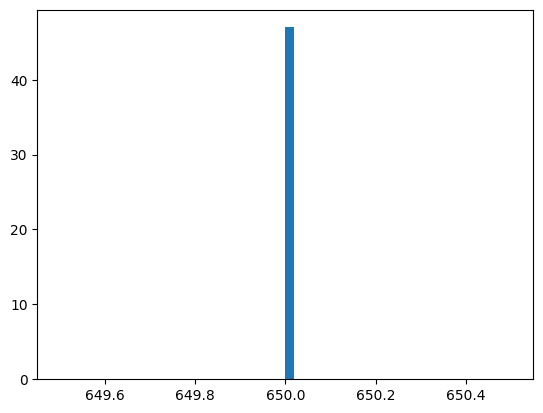

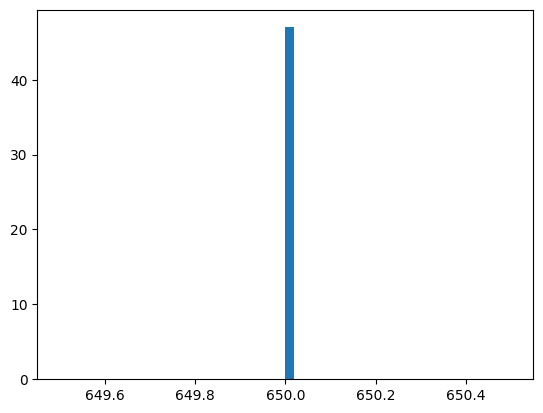

In [578]:
plt.hist(trial_unit_num12.values(), bins=50)
plt.show()
plt.hist(trial_unit_num23.values(), bins=50)
plt.show()
plt.hist(trial_unit_num31.values(), bins=50)
plt.show()

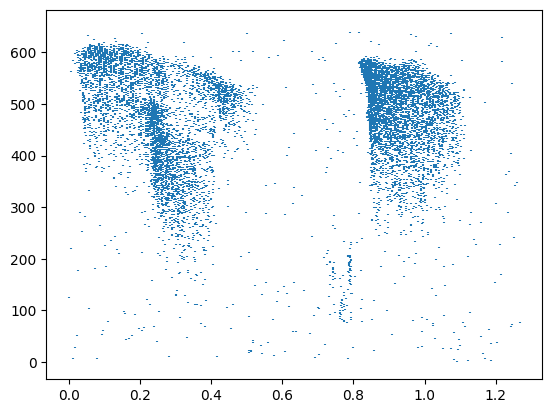

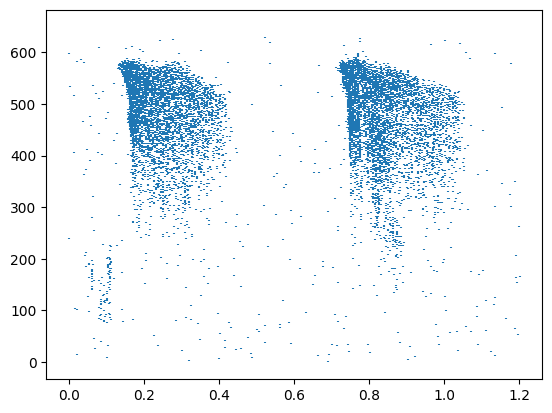

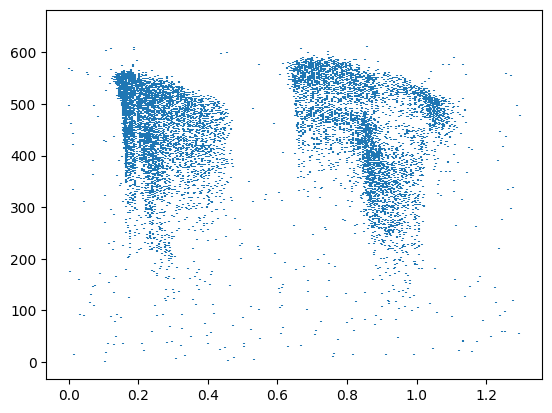

In [580]:
plt.eventplot(plot_spikes12[0])
plt.show()

plt.eventplot(plot_spikes23[0])
plt.show()

plt.eventplot(plot_spikes31[0])
plt.show()

## Model

In [509]:
device = torch.device('cuda')
dtype = torch.float

In [597]:
# convert input to tensors
convert_dict_to_tensor = lambda l: torch.Tensor((np.array([x for x in l.values()]))).to(device)

spikes12 = convert_dict_to_tensor(spikes12)
spikes23 = convert_dict_to_tensor(spikes23)
spikes31 = convert_dict_to_tensor(spikes31)

In [538]:
# tutorial batch size = (256, 100, 700) (batch_num, timepoints, units/neurons)

In [603]:
num_timesteps = 1500
time_duration = 1.5 # sec
time_step = time_duration / num_timesteps

hidden_units = 650
batch_size = spikes12.shape[0]

In [504]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [704]:
weight_scale = 0.2

# w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
# torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

# w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
# torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

v1 = torch.empty((hidden_units, hidden_units), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(v1, mean=0.0, std=weight_scale/np.sqrt(hidden_units))

print("init done")

init done


In [705]:
from IPython.display import clear_output

def live_plot(loss):
    if len(loss) == 1:
        return
    clear_output(wait=True)
    ax = plt.figure(figsize=(3,2), dpi=150).gca()
    ax.plot(range(1, len(loss) + 1), loss)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    ax.xaxis.get_major_locator().set_params(integer=True)
    # sns.despine()
    plt.show()

In [706]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [707]:
# inputs abc = batch x time x units
# w1 cd = inputs x hidden
# v1 cd = hidden x hidden

In [708]:
def run_snn(inputs):
    syn = torch.zeros((batch_size, hidden_units), device=device, dtype=dtype)
    mem = torch.zeros((batch_size, hidden_units), device=device, dtype=dtype)

    mem_rec = []
    spk_rec = []
    
    INPUT_MULTIPLIER = 0.2

    # Compute hidden layer activity
    out = torch.zeros((batch_size, hidden_units), device=device, dtype=dtype)
    # h1_from_input = torch.einsum("abc,cd->abd", (inputs, w1))
    for t in range(num_timesteps):
        h1 = INPUT_MULTIPLIER * inputs[:,t,:] + torch.einsum("ab,bc->ac", (out, v1))
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = out.detach() # We do not want to backprop through the reset

        new_syn = alpha * syn + h1
        new_mem = (beta * mem + syn) * (1.0 - rst)

        mem_rec.append(mem)
        spk_rec.append(out)
        
        mem = new_mem
        syn = new_syn

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

#     # Readout layer
#     h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
#     flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
#     out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
#     out_rec = [out]
#     for t in range(nb_steps):
#         new_flt = alpha*flt +h2[:,t]
#         new_out = beta*out +flt

#         flt = new_flt
#         out = new_out

#         out_rec.append(out)

#     out_rec = torch.stack(out_rec,dim=1)
    # other_recs = [mem_rec, spk_rec]
    # return out_rec, other_recs
    return mem_rec, spk_rec

In [709]:
def L1_loss_function(x):
    return torch.mean(torch.abs(x))
    # return np.mean(np.abs(x))

In [710]:
def train(input_collection, lr=1e-3, num_epochs=10):
    
    params = [v1]
    optimizer = torch.optim.Adamax(params, lr=lr, betas=(0.9,0.999))

    # log_softmax_fn = nn.LogSoftmax(dim=1)
    # loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(num_epochs):
        
        epoch_loss = torch.zeros(1, dtype=torch.float, requires_grad=True).to(device)
        
        for input in input_collection:
            mem_rec, spk_rec = run_snn(input)

            iteration_loss = L1_loss_function(mem_rec)
            epoch_loss = epoch_loss + iteration_loss

            optimizer.zero_grad()
            epoch_loss.backward()
            optimizer.step()
        loss_hist.append(epoch_loss.item())
        live_plot(loss_hist)
        print("Epoch %i: loss=%.5f"%(e+1, epoch_loss.item()))
        
    return loss_hist

In [711]:
input_collection = [spikes12, spikes23, spikes31]

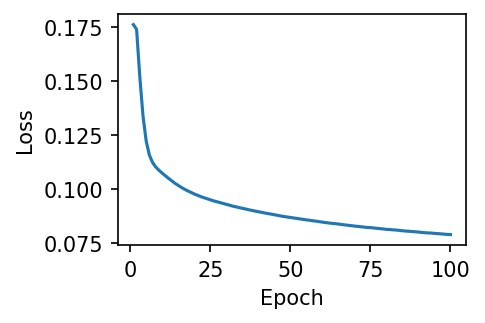

Epoch 100: loss=0.07897


In [712]:
loss_hist = train([spikes12], lr=2e-3, num_epochs=100)

In [713]:
from matplotlib.gridspec import GridSpec

In [714]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

In [715]:
mem_rec, spk_rec = run_snn(spikes12)

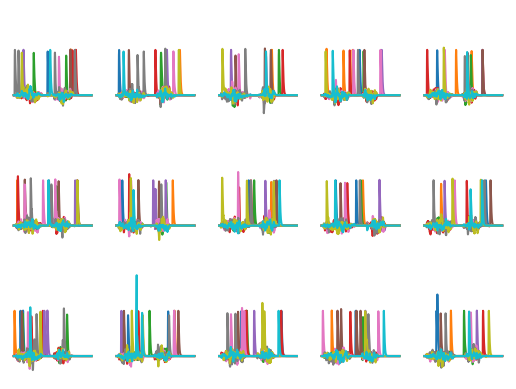

In [716]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec[:,:,:10])

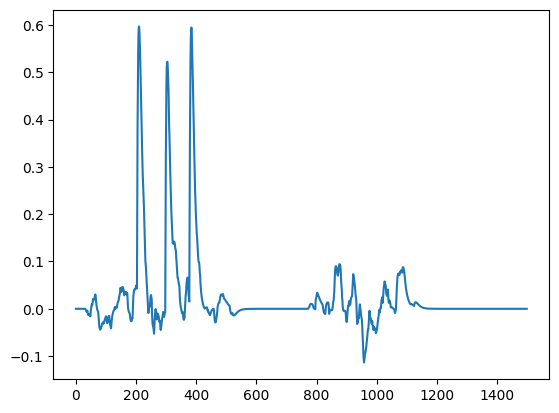

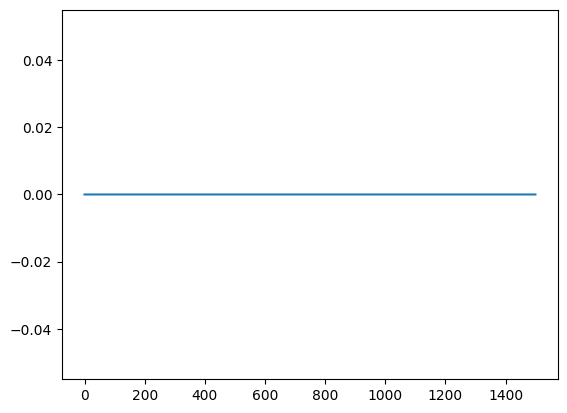

In [717]:
plt.plot(mem_rec[0,:,10].cpu().detach())
# plt.xlim([600,800])
plt.show()
plt.plot(spk_rec[0,:,10].cpu().detach())
# plt.xlim([600,800])
plt.show()

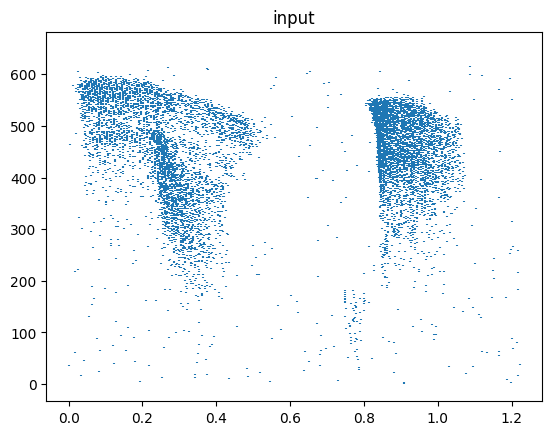

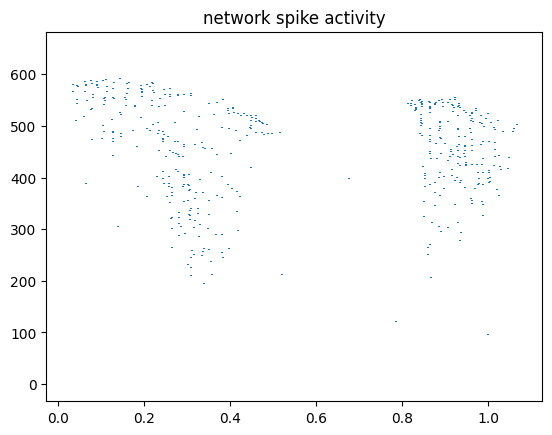

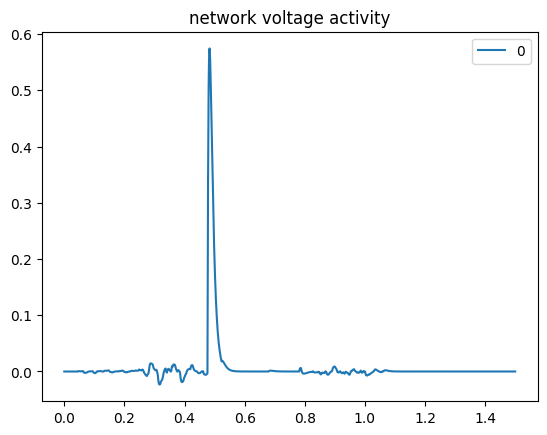

In [718]:
# [30,500:800,500:505]
spike_data = convert_for_plotting2(t, spikes12[30].cpu())
plt.title('input')
plt.eventplot(spike_data)
plt.show()

spike_data = convert_for_plotting2(t, spk_rec[30].cpu().detach().numpy())
plt.title('network spike activity')
plt.eventplot(spike_data)
plt.show()

plt.title('network voltage activity')
plt.plot(t[:], mem_rec[30,:,0].cpu().detach().numpy())
plt.legend([x for x in range(mem_rec.shape[-1])])
plt.show()

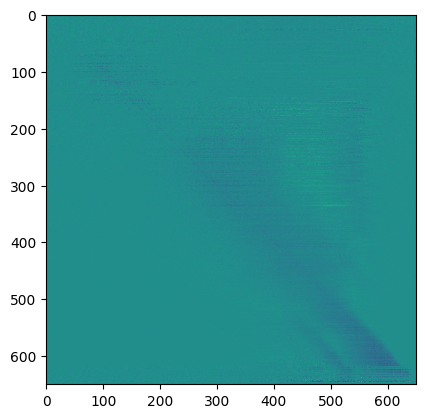

In [719]:
plt.imshow(v1.cpu().detach())

In [720]:
# TRY DIGIT SEQUENCE THE NETWORK HAS NEVER SEEN

In [729]:
# CREATING THE NEW SEQUENCE

units1, times1, trials_num1 = get_digit_data(Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_train.h5", get_digit_inds(0, 1))
units6, times6, trials_num6 = get_digit_data(Path.home() / "RANCZLAB-NAS/iakov/heidelberg_digits/shd_train.h5", get_digit_inds(0, 6))

# PAIRING DIGITS TOGETHER
units16 = []
times16 = []

for i in range(trials_num1): # combine each of 47 trials
    units16.append(np.concatenate((units1[i], units6[i])))
    times16.append(np.concatenate((times1[i], times6[i] + times1[i][-1])))

units16, times16 = trim_to_length(units16, times16, max_time_cut=MAX_TIME)

spikes16, plot_spikes16 = {}, {}

for i in range(trials_num1):
    t, spikes16[i] = resample(units16[i], times16[i], MAX_TIME, FREQ, pad_length = PAD_LENGTH)
    plot_spikes16[i] = convert_for_plotting2(t, spikes16[i])
    
spikes16 = convert_dict_to_tensor(spikes16)

In [734]:
mem_rec, spk_rec = run_snn(spikes16)

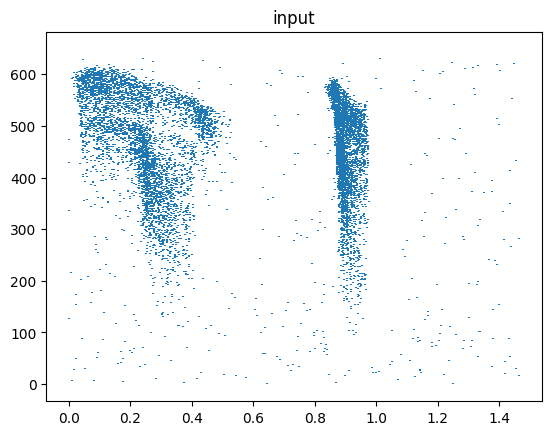

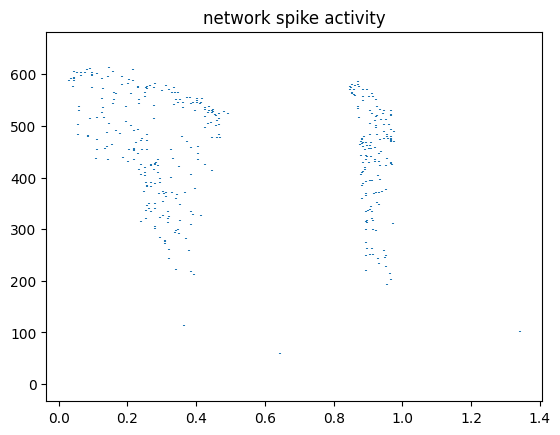

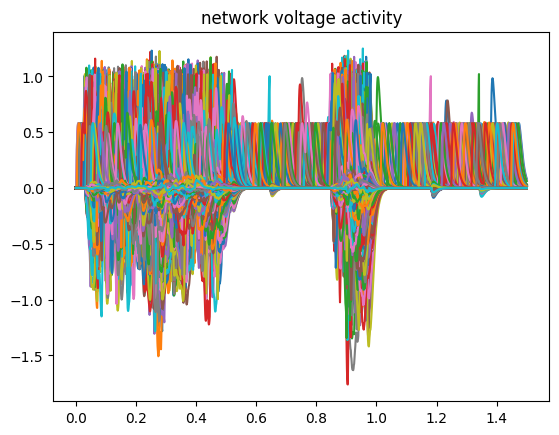

In [735]:
# [30,500:800,500:505]
spike_data = convert_for_plotting2(t, spikes16[0].cpu())
plt.title('input')
plt.eventplot(spike_data)
plt.show()

spike_data = convert_for_plotting2(t, spk_rec[0].cpu().detach().numpy())
plt.title('network spike activity')
plt.eventplot(spike_data)
plt.show()

plt.title('network voltage activity')
plt.plot(t[:], mem_rec[0,:,:].cpu().detach().numpy())
# plt.legend([x for x in range(mem_rec.shape[-1])])
plt.show()